In [2]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=9
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [3]:
# data wrangling: load Fashion-MNIST
KMNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


KMNIST_train = torchvision.datasets.KMNIST(
        '~/data/kmnist',
        train=True,
        download=True,
        transform=KMNIST_transform)



KMNIST_test = torchvision.datasets.KMNIST(
        '~/data/kmnist',
        train=False,
        download=False,
        transform=KMNIST_transform)


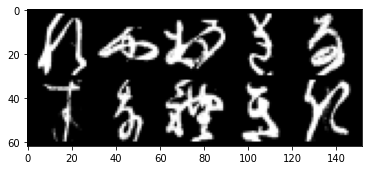

In [4]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = KMNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [5]:
kmnist_train_loader = torch.utils.data.dataloader.DataLoader(
    KMNIST_train,
    batch_size=128,
    shuffle=True
)

kmnist_test_loader = torch.utils.data.dataloader.DataLoader(
    KMNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [6]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [7]:
#set up the training routine
kmnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

kmnist_train_optimizer = torch.optim.Adam(kmnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
KMNIST_PATH = "KMNIST_weights_seed={}.pth".format(s)
#print(FMNIST_PATH)

In [8]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [9]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(kmnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(kmnist_train_loader):
            output = kmnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            kmnist_train_optimizer.step()
            kmnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(KMNIST_PATH))
    torch.save(kmnist_model.state_dict(), KMNIST_PATH)

In [10]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


In [11]:
#predict in distribution
KMNIST_PATH = "KMNIST_weights_seed={}.pth".format(s)

kmnist_model = NN(num_classes=10)
print("loading model from: {}".format(KMNIST_PATH))
kmnist_model.load_state_dict(torch.load(KMNIST_PATH))
kmnist_model.eval()

acc = []

max_len = len(kmnist_test_loader)
for batch_idx, (x, y) in enumerate(kmnist_test_loader):
        output = kmnist_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on KMNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: KMNIST_weights_seed=9.pth
Batch 0/79 	Accuracy 86%
Batch 10/79 	Accuracy 88%
Batch 20/79 	Accuracy 90%
Batch 30/79 	Accuracy 88%
Batch 40/79 	Accuracy 84%
Batch 50/79 	Accuracy 91%
Batch 60/79 	Accuracy 88%
Batch 70/79 	Accuracy 91%
overall test accuracy on KMNIST: 90.24 %


# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [12]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [13]:
#KMNIST_NN_Std_prec_00001 = get_Hessian_NN(model=kmnist_model, train_loader=kmnist_train_loader, prec0=0.0001,verbose=False)
#torch.save(KMNIST_NN_Std_prec_00001, 'Hessian_prec00001_KMNIST.pth')

In [14]:
KMNIST_NN_Std_prec_00001 = torch.load('Hessian_prec00001_KMNIST.pth')

## Now we want to look at the single layers of our network, and how they behave w.r.t. the variance
* every tensor represents one of the six layers of out network


## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [15]:
import seaborn as sns
def visualize(tensor):
    output = tensor[0][0]
    for i in range(1, len(tensor[0])):
        output = np.concatenate((output, tensor[0][i]))
    output = output.transpose(2, 0, 1).reshape(5, -1)
    heatmap = sns.heatmap(output)
    plt.xticks = (np.arange(0, step=20))
    plt.show()
   

In [16]:
#visualize(MNIST_NN_Hessian_diag_10)

In [17]:
def meancalc(Hessian_diag_x):
    i = 0 
    for name, parameter in kmnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean variance of layer {0:s}: {1:.4f}".format(name, mean.item()))
        i += 1
    


In [18]:
meancalc(Hessian_diag_x=KMNIST_NN_Std_prec_00001)

mean variance of layer 0.weight: 23.2667
mean variance of layer 0.bias: 9.5155
mean variance of layer 3.weight: 48.5673
mean variance of layer 3.bias: 35.6538
mean variance of layer 7.weight: 28.9065
mean variance of layer 7.bias: 13.9942


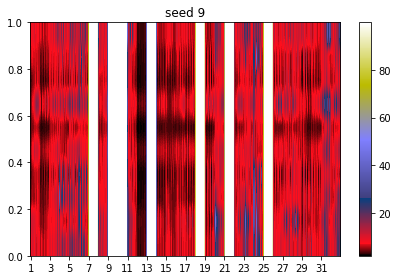

(array([[275.,  98.,  21.,   5.,   1.,   0.,   0.,   0.,   0., 112.],
        [337.,  47.,  12.,   2.,   2.,   0.,   0.,   0.,   0., 112.],
        [363.,  33.,   2.,   2.,   0.,   0.,   0.,   0.,   0., 112.],
        [263., 114.,  20.,   3.,   0.,   0.,   0.,   0.,   0., 112.],
        [389.,  10.,   0.,   1.,   0.,   0.,   0.,   0.,   0., 112.],
        [347.,  50.,   3.,   0.,   0.,   0.,   0.,   0.,   0., 112.],
        [329.,  52.,  14.,   3.,   2.,   0.,   0.,   0.,   0., 112.],
        [315.,  64.,  16.,   1.,   3.,   0.,   1.,   0.,   0., 112.],
        [283.,  77.,  28.,   7.,   1.,   3.,   1.,   0.,   0., 112.],
        [292.,  83.,  17.,   7.,   1.,   0.,   0.,   0.,   0., 112.]]),
 array([ 1.9903178, 11.791283 , 21.592247 , 31.393211 , 41.194176 ,
        50.99514  , 60.796104 , 70.59707  , 80.39803  , 90.199    ,
        99.99996  ], dtype=float32),
 <a list of 10 Lists of Patches objects>)

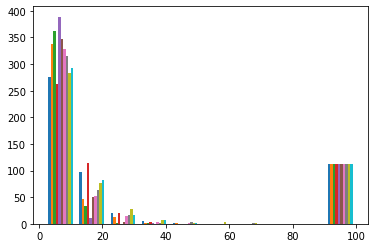

In [19]:
plt.imshow(KMNIST_NN_Std_prec_00001[4], cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
#plt.savefig('linear_seed1000={}'.format(s))

plt.hist(KMNIST_NN_Std_prec_00001[4])

In [20]:
"""
mnist_number = 9
linear_layer_index = 4 #linear layer has index 4
linear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))

#plot setup
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

#iterate through the features and plot them
for i in range(len(layer_split)):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))
    axs[i].imshow(layer_split[i])
    axs[i].set_title('feature '+str(i+1))
"""

"\nmnist_number = 9\nlinear_layer_index = 4 #linear layer has index 4\nlinear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]\n\n#reshape the flattened array to 32* (4x4)\nlayer_split = np.array_split(np.array(linear_layer), 32)\nfor i in range(len(layer_split)-1):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n\n#plot setup\nfig, axs = plt.subplots(4,8, figsize=(20, 15))\nfig.subplots_adjust(hspace = .001, wspace=.001)\naxs = axs.ravel()\n\n#iterate through the features and plot them\nfor i in range(len(layer_split)):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n    axs[i].imshow(layer_split[i])\n    axs[i].set_title('feature '+str(i+1))\n"

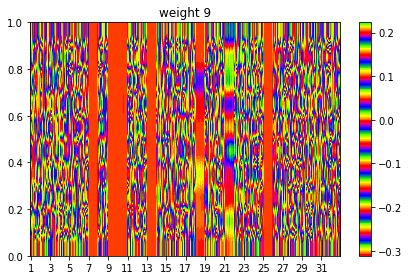

(array([[0., 0., 0., ..., 2., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 2., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 2., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 array([-0.3115186 , -0.25804463, -0.20457065, -0.15109669, -0.09762271,
        -0.04414873,  0.00932525,  0.06279922,  0.1162732 ,  0.16974717,
         0.22322115], dtype=float32),
 <a list of 512 Lists of Patches objects>)

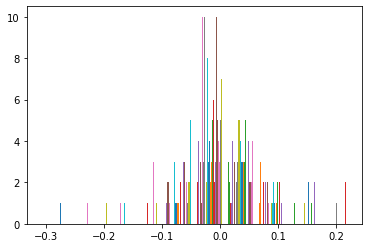

In [21]:
for name, parameters in kmnist_model.named_parameters():
    if name == '7.weight':
        a = parameters

b = a.detach().numpy()

plt.imshow(b, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('weight {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
plt.hist(b)

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.]]),
 array([-1.5569967e-05, -1.4011715e-05, -1.2453464e-05, -1.0895213e-05,
        -9.3369608e-06, -7.7787090e-06, -6.2204576e-06, -4.6622058e-06,
        -3.1039542e-06, -1.5457027e-06,  1.2548900e-08], dtype=float32),
 <a list of 10 Lists of Patches objects>)

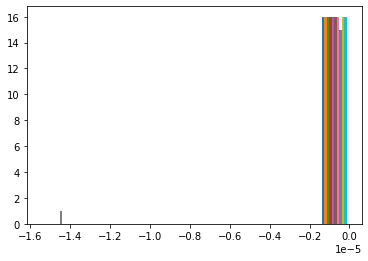

In [22]:
to_hist = []
target_feature = 9
for i in range(10):
    weight = a[i].detach().numpy()
    weight = np.array_split(np.array(weight), 32)
    to_hist.append(weight[target_feature -1])
plt.hist(to_hist)

In [23]:
"""
observe = [1, 8, 13, 14, 17, 24]
f,c = plt.subplots(3,2)
plt.figure(figsize=(20,20))
c = c.ravel()
for i in range(10):
    test = np.array_split(a[i].detach().numpy(), 32)
for idx, ax in enumerate(c):
    ax.set_title(str(observe[idx] +1))
    ax.hist(test[observe[idx]])
plt.tight_layout()
        
    
#for idx,ax in enumerate(a):
 #   ax.hist(test[observe[idx]])
 """

'\nobserve = [1, 8, 13, 14, 17, 24]\nf,c = plt.subplots(3,2)\nplt.figure(figsize=(20,20))\nc = c.ravel()\nfor i in range(10):\n    test = np.array_split(a[i].detach().numpy(), 32)\nfor idx, ax in enumerate(c):\n    ax.set_title(str(observe[idx] +1))\n    ax.hist(test[observe[idx]])\nplt.tight_layout()\n        \n    \n#for idx,ax in enumerate(a):\n #   ax.hist(test[observe[idx]])\n '

# visualize the second conv layer kernels

### first visualize the uncertaintys of the kernels

29


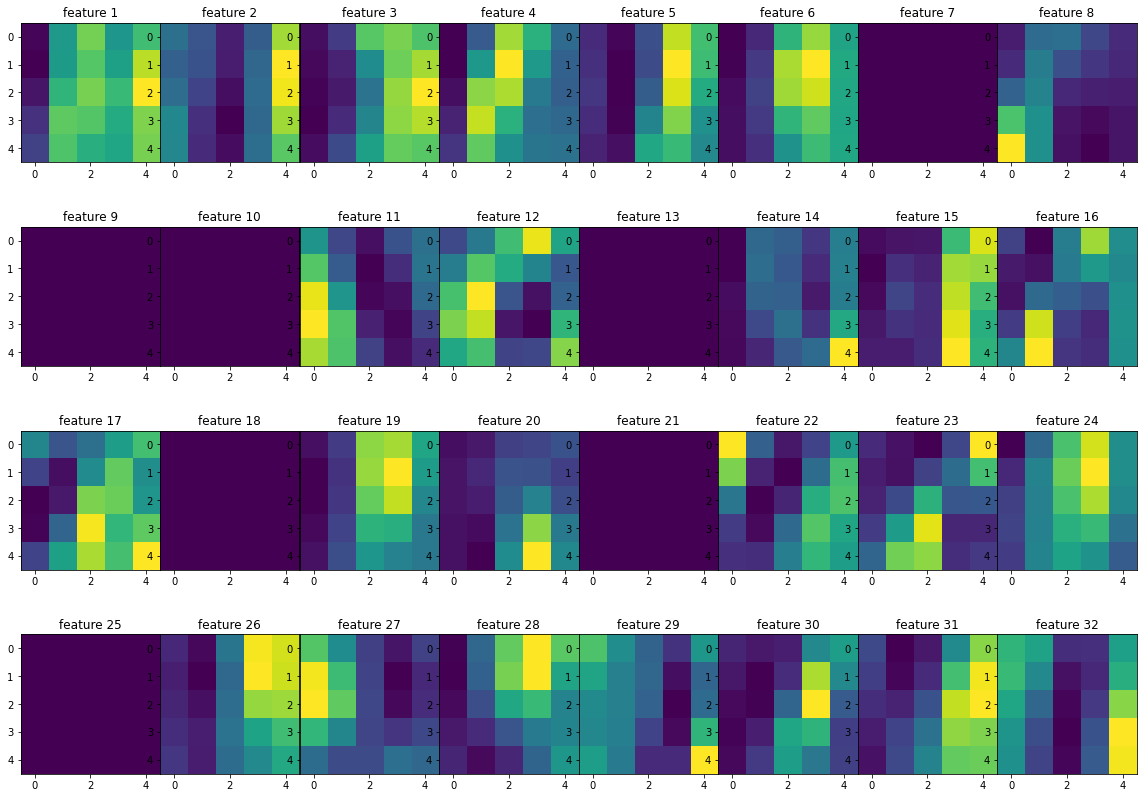

In [24]:
from random import randint

#choose a random between 0 and 31 for 2nd dimension
j = randint(0, 31)

fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
print(j)
for i in range(32):
    #for j in range(32):
    axs[i].imshow(KMNIST_NN_Std_prec_00001[2][i][j])
    axs[i].set_title('feature '+str(i+1))

### in kernels with high uncertainty the biases are maximal (100 for precision 0.0001)

In [25]:
print(KMNIST_NN_Std_prec_00001[3])

tensor([ 15.0078,  17.0448,  17.5376,  16.2001,  17.5204,  14.3734, 100.0000,
         18.9304, 100.0000, 100.0000,  16.1867,  12.8399, 100.0000,  17.7029,
         15.5130,  13.5677,  18.7158, 100.0000,  18.6241,  22.8459, 100.0000,
         19.4366,  21.7401,  15.5591, 100.0000,  25.3378,  12.9629,  14.0662,
         18.9544,  20.7845,  15.4289,  24.0420])


## Now viualize the weights of the kernels in the second conv layer (3.weight)

18


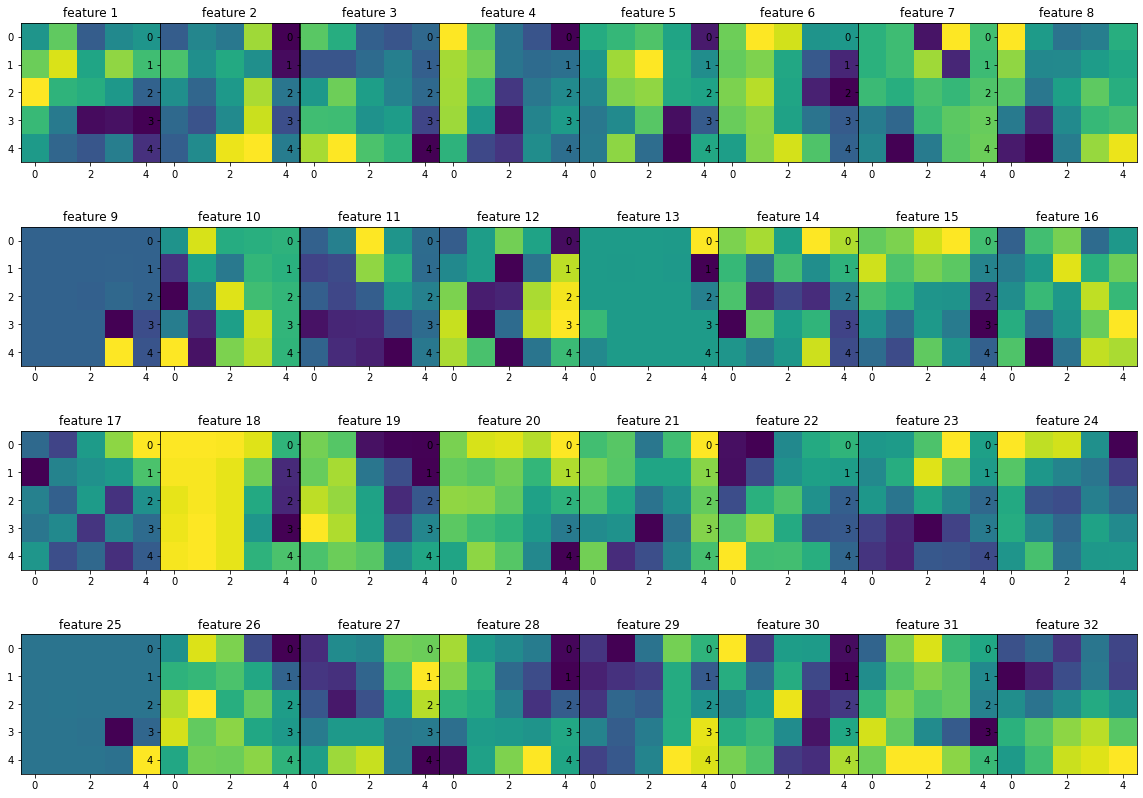

In [26]:
for name, parameters in kmnist_model.named_parameters():
    if name == '3.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#choose random number between 0 and 31 for 2nd dimension
j = randint(0, 31)
#j = …
print(j)
for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][j])
    axs[i].set_title('feature '+str(i+1))
    
#interesting j values: 10, 13

### look at the biases of the 3rd layer (3.bias)

In [27]:
for name, parameters in kmnist_model.named_parameters():
    if name == '3.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)
#plt.hist(params_arr)

[-2.6027549e-02  1.1504281e-03 -3.6634204e-03  5.5413418e-03
  1.0609571e-02  8.5361740e-03  2.4371792e-04 -5.9966490e-02
 -1.5292886e-05 -1.5214405e-03  2.8246747e-02 -4.7365583e-02
 -6.3359323e-05 -3.5050739e-02  2.0677615e-03 -3.7783325e-02
 -3.2444812e-02 -9.8673134e-08 -4.0679224e-02 -4.6183214e-02
 -9.5325802e-03  1.6837735e-02  1.2553165e-02  1.0315559e-01
 -7.5139417e-07 -8.9956559e-02 -1.5100261e-02 -5.0451811e-02
  4.3108251e-02 -6.9673963e-02  1.8186102e-02 -6.6544823e-03]


## visualize the first conv layers kernels

### first visualize the uncertaintys of the kernels

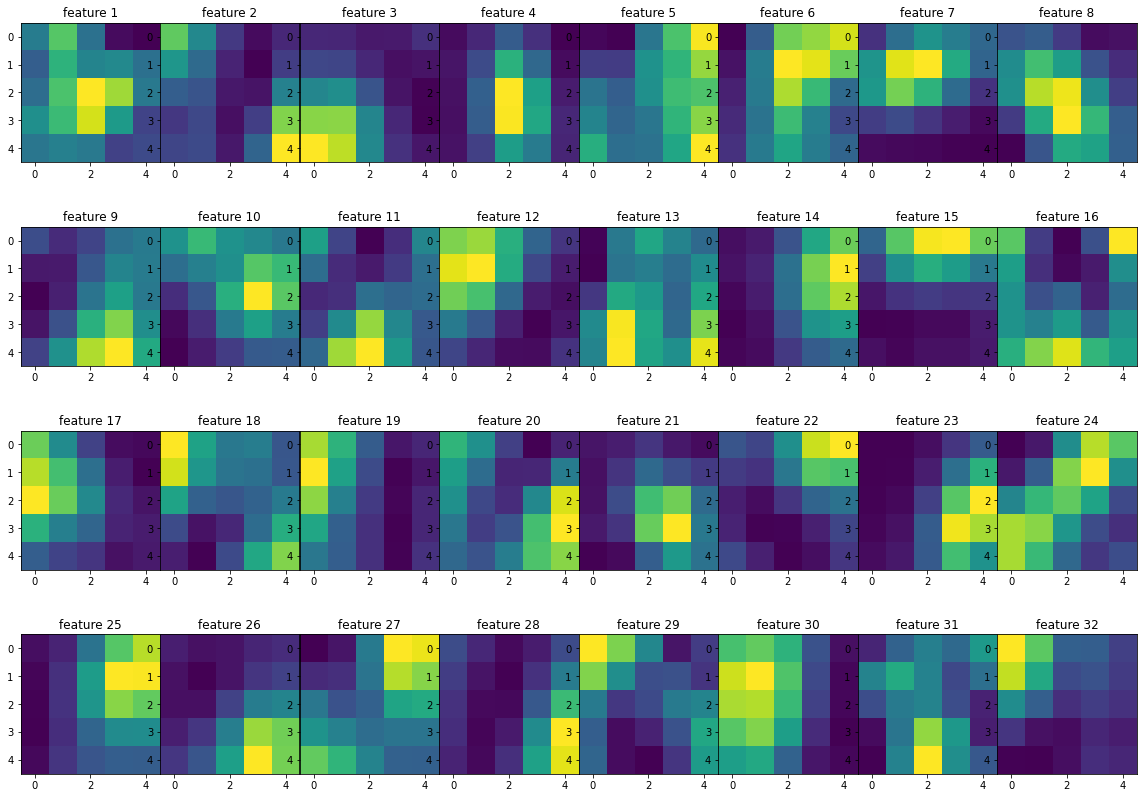

In [28]:
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(KMNIST_NN_Std_prec_00001[0][i][0])
    axs[i].set_title('feature '+str(i+1))

In [29]:
print(KMNIST_NN_Std_prec_00001[1])

tensor([12.2728, 13.3727,  8.2659,  3.4375, 15.7620, 10.0441,  3.2782,  3.2512,
         9.7760,  4.6184, 13.9339,  7.8129, 16.6580,  9.5948,  4.2233,  9.7658,
        13.3133, 15.7959, 14.3619, 11.6091,  3.1293,  5.1895,  3.3033,  6.9964,
        12.1737,  7.4856, 14.2621,  4.6284, 14.1589,  3.0764, 15.3413, 13.6045])


## now visualize the weights of kernels in first conv layer

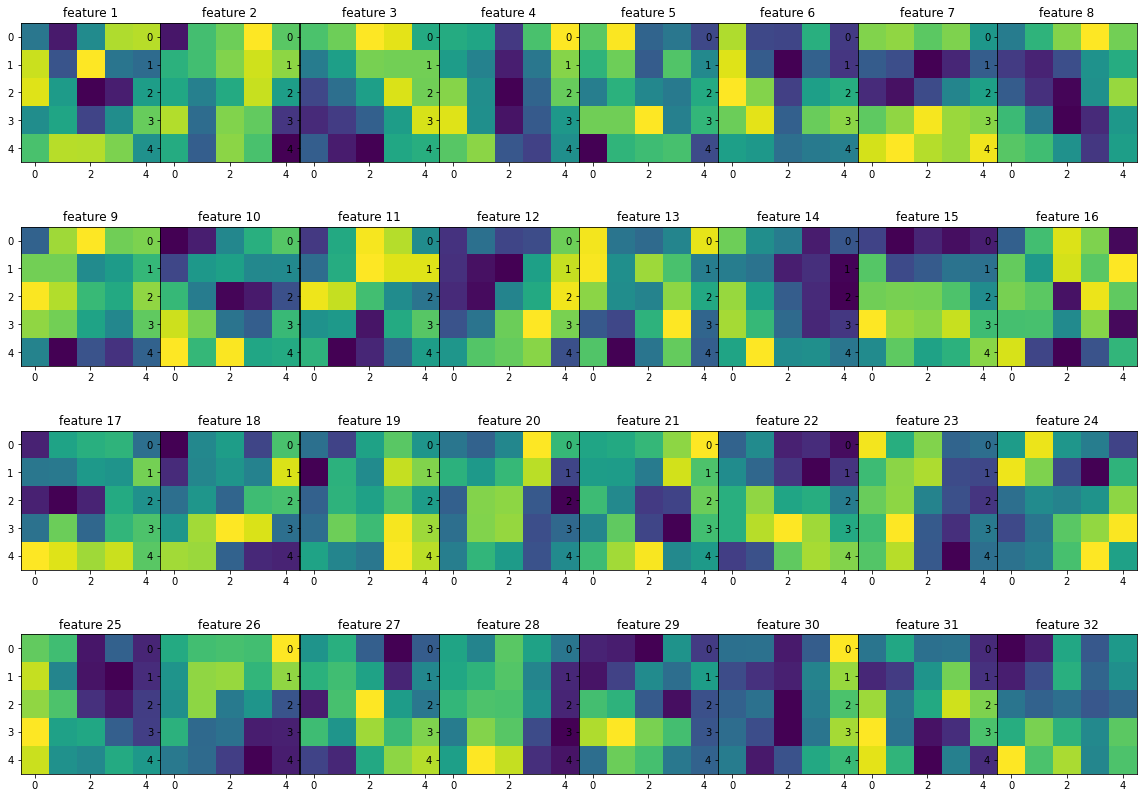

In [30]:
for name, parameters in kmnist_model.named_parameters():
    if name == '0.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][0])
    axs[i].set_title('feature '+str(i+1))